<center><h1>Exploring the Effectiveness of Various Machine Learning Approaches</h1></center>

Dylan Andrews

Import packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
import random
import math
from statistics import mode
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Supervised, Semi-Supervised, and Unsupervised Learning
In this first section, I'll be training models to diagnose breast cancer using supervised, semi-supervised, and unsupervised learning and comparing their results

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
all_data = pd.read_csv('../data/wdbc.data')
malignant_data = all_data[all_data['Diagnosis'] == 'M']
benign_data = all_data[all_data['Diagnosis'] == 'B']
features = list(all_data.columns)
features.remove('ID_number')
features.remove('Diagnosis')
target = ['Diagnosis']

### (b) Monte-Carlo Simulation

In [3]:
# splitting up train and test data
malignant_x_train, malignant_x_test, malignant_y_train, malignant_y_test = train_test_split(malignant_data[features], malignant_data[target], test_size = 0.2)
benign_x_train, benign_x_test, benign_y_train, benign_y_test = train_test_split(benign_data[features], benign_data[target], test_size = 0.2)

# getting all train and test data

train_x_data = pd.concat([malignant_x_train, benign_x_train])
train_y_data = pd.concat([malignant_y_train, benign_y_train])

test_x_data = pd.concat([malignant_x_test, benign_x_test])
test_y_data = pd.concat([malignant_y_test, benign_y_test])

#### (i) Supervised Learning

For the supervised learning portion, I'll just be using a L1-penalized SVM using normalized data and reporting various statistics

In [4]:

def supervised_learning(plot_roc_and_report_confusion_matrix):

    # Normalize training and testing input data using StandardScaler
    # First, fit the scaler on the combined training and test data.
    # Then, transform the training and testing data separately.
    scaler = StandardScaler().fit(pd.concat([train_x_data, test_x_data]))
    x_train_normalized = pd.DataFrame(scaler.transform(train_x_data), columns=train_x_data.columns)
    x_test_normalized = pd.DataFrame(scaler.transform(test_x_data), columns=test_x_data.columns)

    # Define the list of C (Inverse of regularization strength) values to perform cross-validation on.
    c_cross_val_range = [10e-4,10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3, 10e4, 10e5, 10e6] 

    best_c = 0
    best_cross_val_score = 0

    # Cross-validation loop to choose the best C (Inverse of regularization strength)
    # We are using LinearSVC with 'l1' penalty and a maximum of 5000 iterations.
    for c in c_cross_val_range:
        clf = LinearSVC(penalty='l1', C=c, dual=False, max_iter= 5000)
        avg_cross_val_score = np.mean(cross_val_score(clf, X= x_train_normalized, y=train_y_data.to_numpy().ravel(), cv=5, n_jobs=-1))

        # If the cross-validation score of the current C value is greater than the best score so far,
        # Update the best C value and the best cross-validation score.
        if avg_cross_val_score > best_cross_val_score:
            best_c = c
            best_cross_val_score = avg_cross_val_score
                
    # Train the final model with the best C value found from cross-validation.
    clf_final = LinearSVC(penalty='l1', C=best_c, dual=False, max_iter= 5000)
    clf_final.fit(x_train_normalized, train_y_data.to_numpy().ravel())

    # Predict on the test and train datasets.
    y_pred = clf_final.predict(x_test_normalized)
    y_pred_train = clf_final.predict(x_train_normalized)
    
    # Create a dictionary to store various performance metrics.
    results = {}
    results["Accuracy Score"] = accuracy_score(test_y_data, y_pred)
    results["Precision Score"] = precision_score(test_y_data, y_pred, pos_label='M')
    results["Recall Score"] = recall_score(test_y_data, y_pred, pos_label='M')
    results["F1 Score"] = f1_score(test_y_data, y_pred, pos_label='M')
    results["AUC Score"] = roc_auc_score(test_y_data, clf_final.decision_function(x_test_normalized))
    
    # If plot_roc_and_report_confusion_matrix is True, plot the ROC curve and confusion matrix for train and test datasets.
    if plot_roc_and_report_confusion_matrix:
        print("Train ROC Curve")
        RocCurveDisplay.from_estimator(clf_final, x_train_normalized, train_y_data)
        plt.show()
        print("Test ROC Curve")
        RocCurveDisplay.from_estimator(clf_final, x_test_normalized, test_y_data)
        plt.show()
        print("Train Confusion Matrix")
        cm_train = confusion_matrix(train_y_data, y_pred_train, labels=clf_final.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=clf_final.classes_)
        disp.plot()
        plt.show()
        print("Test Confusion Matrix")
        cm_test = confusion_matrix(test_y_data, y_pred, labels=clf_final.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf_final.classes_)
        disp.plot()
        plt.show()

    # Return the dictionary of performance metrics.
    return results


#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

For the semi-supervised learning portion, I am also using an L1-penalized SVM with normalized data for consistency, but am also implementing self training by labeling half the training data and not labeling the other half, and iteratively adding the unlabled data based on the distance to the hyperplane and retraining until all data are used.

In [5]:
# This function simply prepares the labeled and unlabled data for use in the semi-supervised learning algorithm
def semi_supervised_learning_A():

    # Creating a copy of the train_x_data and adding the 'Diagnosis' column to it.
    # This helps us to perform operations on the entire dataset at once.
    x_and_y_train = train_x_data.copy()
    x_and_y_train['Diagnosis'] = train_y_data['Diagnosis']

    # Separate the data into positive and negative cases based on the 'Diagnosis' column.
    # 'M' signifies malignant (positive) and 'B' signifies benign (negative).
    pos_train = x_and_y_train[x_and_y_train['Diagnosis'] == 'M']
    neg_train = x_and_y_train[x_and_y_train['Diagnosis'] == 'B']

    # Shuffle and split the positive cases into two equal parts: labeled and unlabeled.
    pos_train_shuffled = pos_train.sample(frac=1)
    pos_train_splits = np.array_split(pos_train_shuffled, 2)
    labeled_pos_train = pos_train_splits[0]
    unlabeled_pos_train = pos_train_splits[1]

    # Shuffle and split the negative cases into two equal parts: labeled and unlabeled.
    neg_train_shuffled = neg_train.sample(frac=1)
    neg_train_splits = np.array_split(neg_train_shuffled, 2)
    labeled_neg_train = neg_train_splits[0]
    unlabeled_neg_train = neg_train_splits[1]

    # Concatenate the labeled positive and negative cases to form the final labeled data.
    labeled_train_data = pd.concat([labeled_pos_train, labeled_neg_train])

    # Concatenate the unlabeled positive and negative cases to form the final unlabeled data.
    unlabeled_train_data = pd.concat([unlabeled_pos_train, unlabeled_neg_train])

    # Normalize the labeled data.
    scaler = StandardScaler().fit(pd.concat([train_x_data, test_x_data]))
    x_train_normalized = pd.DataFrame(scaler.transform(labeled_train_data[features]), columns=train_x_data.columns)

    # Define the list of C values (Inverse of regularization strength) for cross-validation.
    c_cross_val_range = [10e-4,10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3, 10e4, 10e5, 10e6] 

    best_c = 0
    best_cross_val_score = 0

    # Cross-validation loop to choose the best C value.
    # LinearSVC with 'l1' penalty and maximum iterations of 5000 is used.
    for c in c_cross_val_range:
        clf = LinearSVC(penalty='l1', C=c, dual=False, max_iter= 5000)
        avg_cross_val_score = np.mean(cross_val_score(clf, X= x_train_normalized, y=labeled_train_data[target].to_numpy().ravel(), cv=5, n_jobs=-1))

        # If the cross-validation score for the current C value is greater than the best score so far,
        # update the best C value and the best cross-validation score.
        if avg_cross_val_score > best_cross_val_score:
            best_c = c
            best_cross_val_score = avg_cross_val_score

    # Return the labeled data, unlabeled data and the best C value.
    return labeled_train_data, unlabeled_train_data, best_c


##### (B)

In [6]:
# This function performs a semi-supervised learning process. It uses labeled and unlabeled data along with
# the optimal regularization strength parameter (C) and a flag to plot ROC curves and confusion matrices.
def semi_supervised_learning_B(labeled_train_data, unlabeled_train_data, best_c, plot_roc_and_report_confusion_matrix):
    
    # Data normalization
    scaler = StandardScaler().fit(pd.concat([train_x_data, test_x_data]))
    
    # Normalize labeled and unlabeled training data
    x_labeled_train_normalized = pd.DataFrame(scaler.transform(labeled_train_data[features]), columns=train_x_data.columns)
    x_unlabeled_train_normalized = pd.DataFrame(scaler.transform(unlabeled_train_data[features]), columns=train_x_data.columns)
    
    # Create Linear Support Vector Classifier with optimal C
    clf = LinearSVC(penalty='l1', C=best_c, dual=False, max_iter= 5000)
    
    # Train classifier on labeled data
    clf.fit(x_labeled_train_normalized, labeled_train_data[target].to_numpy().ravel())
    
    # This loop iterates over unlabeled training data
    for i in range(len(x_unlabeled_train_normalized)):
        
        # Initialize variables for longest distance and its row
        longest_distance = 0
        longest_distance_row = None
        
        # Loop over unlabeled data and calculate the distance to the hyperplane for each instance
        for row in x_unlabeled_train_normalized.itertuples():
            # Create DataFrame from row
            d = dict(row._asdict())
            row_df = pd.DataFrame([d])
            
            # Compute distance to hyperplane
            y = clf.decision_function(row_df[features])
            w_norm = np.linalg.norm(clf.coef_)
            dist = y / w_norm
            
            # If current distance is larger than the longest one, update the longest distance and assign a label to the row
            if dist > longest_distance:
                row_df['Diagnosis'] = clf.predict(row_df[features])[0]
                longest_distance_row = row_df
                longest_distance = dist
                
        # Remove instance from unlabeled data and add it to labeled data
        x_unlabeled_train_normalized = x_unlabeled_train_normalized.drop(row.Index)
        labeled_train_data = pd.concat([labeled_train_data, longest_distance_row])
        x_labeled_train_normalized = pd.DataFrame(scaler.transform(labeled_train_data[features]), columns=train_x_data.columns)
        
        # Re-train the classifier with the newly labeled data
        clf = LinearSVC(penalty='l1', C=best_c, dual=False, max_iter= 5000)
        clf.fit(x_labeled_train_normalized, labeled_train_data[target].to_numpy().ravel())
        
    # Normalize the test data
    x_test_normalized = pd.DataFrame(scaler.transform(test_x_data), columns=train_x_data.columns)
    
    # Make predictions on test and train data
    y_pred = clf.predict(x_test_normalized)
    y_pred_train = clf.predict(x_labeled_train_normalized)
    
    # Create dictionary to store model performance metrics
    results = {}
    results["Accuracy Score"] = accuracy_score(test_y_data, y_pred)
    results["Precision Score"] = precision_score(test_y_data, y_pred, pos_label='M')
    results["Recall Score"] = recall_score(test_y_data, y_pred, pos_label='M')
    results["F1 Score"] = f1_score(test_y_data, y_pred, pos_label='M')
    results["AUC Score"] = roc_auc_score(test_y_data, clf.decision_function(x_test_normalized))
    
    # Plot ROC curves and confusion matrices for both train and test data, if specified
    if plot_roc_and_report_confusion_matrix:
        print("Train ROC Curve")
        RocCurveDisplay.from_estimator(clf, x_labeled_train_normalized, labeled_train_data[target])
        plt.show()
        print("Test ROC Curve")
        RocCurveDisplay.from_estimator(clf, x_test_normalized, test_y_data)
        plt.show()
        print("Train Confusion Matrix")
        cm_train = confusion_matrix(labeled_train_data[target], y_pred_train, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=clf.classes_)
        disp.plot()
        plt.show()
        print("Test Confusion Matrix")
        cm_test = confusion_matrix(test_y_data, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf.classes_)
        disp.plot()
        plt.show()
       
    # Return the results dictionary
    return results


Train ROC Curve


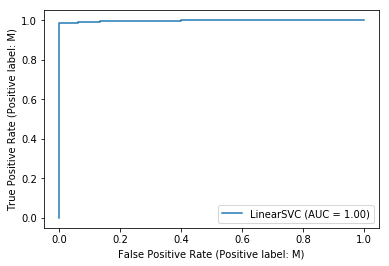

Test ROC Curve


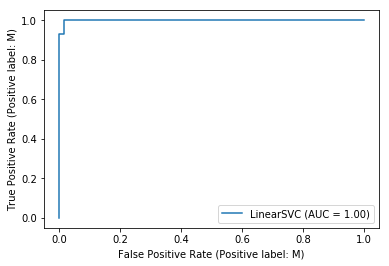

Train Confusion Matrix


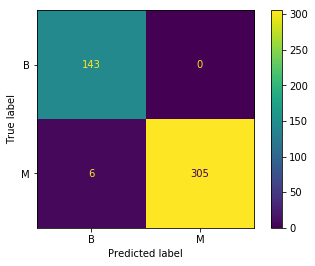

Test Confusion Matrix


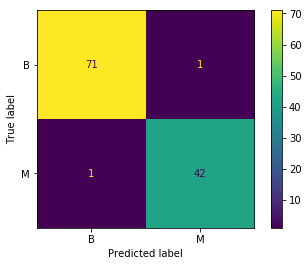

{'Accuracy Score': 0.9826086956521739, 'Precision Score': 0.9767441860465116, 'Recall Score': 0.9767441860465116, 'F1 Score': 0.9767441860465116, 'AUC Score': 0.999031007751938}


In [7]:
labeled_train_data, unlabeled_train_data, best_c = semi_supervised_learning_A()

print(semi_supervised_learning_B(labeled_train_data, unlabeled_train_data, best_c, True))

#### (iii) Unsupervised Learning

For the unsupervised learning portion, I used a K-means algorithmm with k=2. 

##### (A)

In [8]:
def unsupervised_learning_A():
    
    set_cluster_sums = set()
    for i in range(1000):
        kmeans = KMeans(n_clusters=2, init='random', n_init= 50, random_state=i).fit(train_x_data, train_y_data)
        
        set_cluster_sums.add(sum(kmeans.cluster_centers_[0]) + sum(kmeans.cluster_centers_[1]))
        
    print(set_cluster_sums)
        
unsupervised_learning_A()

{4783.397704241918}


To ensure the algorithm was not trapped in a local minimum, I ran the KMeans with 1000 different initializations, and based on the sums of the centroids, they all turned out to be the same location (it is very unlikely that two different centroids would have the same sum over 30+ vriables). Since I got the same result for all 1000 initializations, it was unlikely that the algorithm was stuck in a local minimum

##### (B)

Train Confusion Matrix


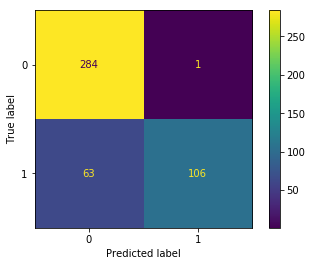

({'Accuracy Score': 0.8590308370044053,
  'Precision Score': 0.9906542056074766,
  'Recall Score': 0.6272189349112426,
  'F1 Score': 0.7681159420289855},
 array([1.24707608e+01, 1.85483573e+01, 8.05525072e+01, 4.89942363e+02,
        9.47847839e-02, 9.11109510e-02, 6.21863997e-02, 3.29469942e-02,
        1.78202017e-01, 6.36658501e-02, 3.01259654e-01, 1.21555706e+00,
        2.13461873e+00, 2.34060231e+01, 7.27016715e-03, 2.34415908e-02,
        2.91319383e-02, 1.05685043e-02, 2.05343573e-02, 3.78478761e-03,
        1.39426196e+01, 2.46417867e+01, 9.12174928e+01, 6.11211816e+02,
        1.30256859e-01, 2.23270836e-01, 2.18827052e-01, 9.03782161e-02,
        2.83344092e-01, 8.37929683e-02]),
 array([1.93597196e+01, 2.18047664e+01, 1.28122430e+02, 1.18161776e+03,
        1.01267757e-01, 1.50337009e-01, 1.77794206e-01, 1.01448598e-01,
        1.91427103e-01, 6.08136449e-02, 7.28286916e-01, 1.18573832e+00,
        5.08672897e+00, 9.19362617e+01, 6.59419626e-03, 3.26592150e-02,
        4.24

In [9]:
def unsupervised_learning_B(plot_roc_and_report_confusion_matrix):
    
    kmeans = KMeans(n_clusters=2, init='random', n_init= 50, random_state=5).fit(train_x_data)
    
    cluster_1 = kmeans.cluster_centers_[0]
    cluster_2 = kmeans.cluster_centers_[1]
    
    distance_df = train_x_data.copy()
    
    distance_df['Diagnosis'] = train_y_data['Diagnosis']
    
    distance_df['clust_1_dist'] = distance_df[features].sub(cluster_1, axis=1).pow(2).sum(axis=1).pow(.5)
    distance_df['clust_2_dist'] = distance_df[features].sub(cluster_2, axis=1).pow(2).sum(axis=1).pow(.5)

    top_30_clust_1 = distance_df.copy().sort_values(by=['clust_1_dist']).head(30)
    top_30_clust_2 = distance_df.copy().sort_values(by=['clust_2_dist']).head(30)
    
    majority_clust_1 = mode(top_30_clust_1['Diagnosis'])
    majority_clust_2 = mode(top_30_clust_2['Diagnosis'])
    

    
    distance_df['kmeans_diagnosis'] = np.where(distance_df['clust_1_dist'] > distance_df['clust_2_dist'], majority_clust_2, majority_clust_1)

    # results dictiolnary 
    results = {}
    results["Accuracy Score"] = accuracy_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'])
    results["Precision Score"] = precision_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'], pos_label='M')
    results["Recall Score"] = recall_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'], pos_label='M')
    results["F1 Score"] = f1_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'], pos_label='M')

    
    if plot_roc_and_report_confusion_matrix:
        print("Train Confusion Matrix")
        cm_train = confusion_matrix(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp.plot()
        plt.show()
        
    return results, cluster_1, cluster_2, majority_clust_1, majority_clust_2
    
unsupervised_learning_B(True)

In [10]:
def unsupervised_learning_C(cluster_1, cluster_2, majority_clust_1, majority_clust_2, plot_roc_and_report_confusion_matrix):
    
    distance_df = test_x_data.copy()
    
    distance_df['Diagnosis'] = test_y_data['Diagnosis']
    
    distance_df['clust_1_dist'] = distance_df[features].sub(cluster_1, axis=1).pow(2).sum(axis=1).pow(.5)
    distance_df['clust_2_dist'] = distance_df[features].sub(cluster_2, axis=1).pow(2).sum(axis=1).pow(.5)
    
    
    distance_df['kmeans_diagnosis'] = np.where(distance_df['clust_1_dist'] > distance_df['clust_2_dist'], majority_clust_2, majority_clust_1)

    # results dictiolnary 
    results = {}
    results["Accuracy Score"] = accuracy_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'])
    results["Precision Score"] = precision_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'], pos_label='M')
    results["Recall Score"] = recall_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'], pos_label='M')
    results["F1 Score"] = f1_score(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'], pos_label='M')
    
    if plot_roc_and_report_confusion_matrix:
        print("Test Confusion Matrix")
        cm_train = confusion_matrix(distance_df['Diagnosis'], distance_df['kmeans_diagnosis'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp.plot()
        plt.show()
    
    return results
    
    


#### (iv) Spectral Clustering

In [11]:
def spectral_cluster_train(plot_roc_and_report_confusion_matrix):
    
    spectral_cluster = SpectralClustering(n_clusters=2, gamma= 1)
    
    distance_df = train_x_data.copy()
    
    distance_df['Diagnosis'] = train_y_data['Diagnosis']
    
    distance_df['Spectral_Cluster_Class'] = spectral_cluster.fit_predict(distance_df[features])
    
#     print(distance_df['Spectral_Cluster_Class'])
    
    
    cluster_0_diagnosis = mode(distance_df[distance_df['Spectral_Cluster_Class'] == 0]['Diagnosis'])
    
    # sometimes there are no results for a class, so if that is the case then assign all the same diagnosis
    try:
        cluster_1_diagnosis = mode(distance_df[distance_df['Spectral_Cluster_Class'] == 1]['Diagnosis'])
    except:
        cluster_1_diagnosis = cluster_0_diagnosis
        
        
    distance_df['Spectral_Diagnosis'] = np.where(distance_df['Spectral_Cluster_Class'] == 0, cluster_0_diagnosis, cluster_1_diagnosis)
        
    # results dictiolnary 
    results = {}
    results["Accuracy Score"] = accuracy_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'])
    results["Precision Score"] = precision_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'], pos_label='M')
    results["Recall Score"] = recall_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'], pos_label='M')
    results["F1 Score"] = f1_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'], pos_label='M')
    
    if plot_roc_and_report_confusion_matrix:
        print("Train Confusion Matrix")
        cm_train = confusion_matrix(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp.plot()
        plt.show()
    
    return results, distance_df           

    


Train Confusion Matrix


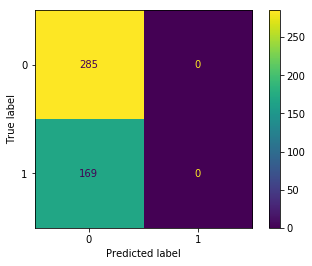

Train Confusion Matrix


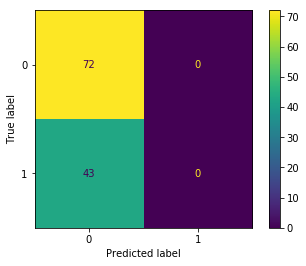

{'Accuracy Score': 0.6260869565217392, 'Precision Score': 0.0, 'Recall Score': 0.0, 'F1 Score': 0.0}


In [12]:
def spectral_cluster_test(distance_df_train, plot_roc_and_report_confusion_matrix):
    
    knn = KNeighborsClassifier(n_neighbors=1).fit(distance_df_train[features], distance_df_train['Spectral_Diagnosis'])
    # using KNN to predict what spectral clustering would classif test set as
    distance_df = test_x_data.copy()
    distance_df['Diagnosis'] = test_y_data['Diagnosis']
    
    distance_df['Spectral_Diagnosis'] = knn.predict(distance_df[features])
    
    
    # results dictiolnary 
    results = {}
    results["Accuracy Score"] = accuracy_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'])
    results["Precision Score"] = precision_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'], pos_label='M')
    results["Recall Score"] = recall_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'], pos_label='M')
    results["F1 Score"] = f1_score(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'], pos_label='M')
    
    if plot_roc_and_report_confusion_matrix:
        print("Train Confusion Matrix")
        cm_train = confusion_matrix(distance_df['Diagnosis'], distance_df['Spectral_Diagnosis'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
        disp.plot()
        plt.show()
    
    return results

results, distance_df = spectral_cluster_train(True)

print(spectral_cluster_test(distance_df, True))

#### (v) Compare

Supervised Learning:
Train ROC Curve


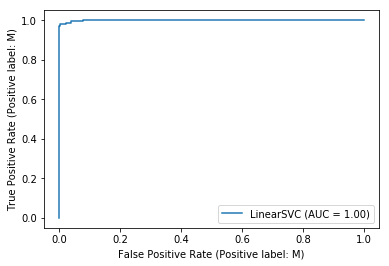

Test ROC Curve


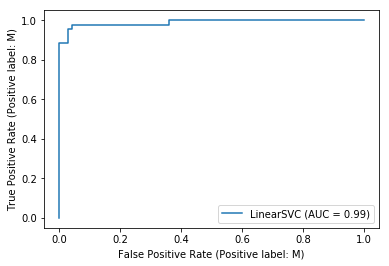

Train Confusion Matrix


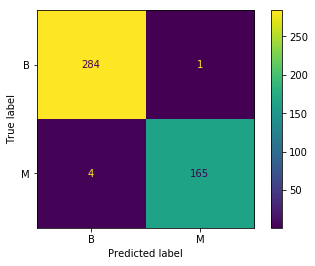

Test Confusion Matrix


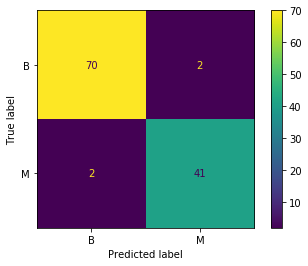

Semi- Supervised Learning:
Train ROC Curve


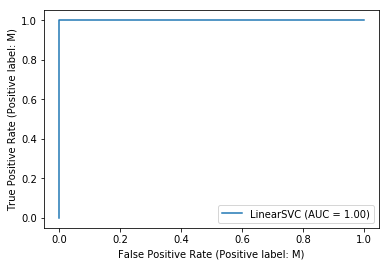

Test ROC Curve


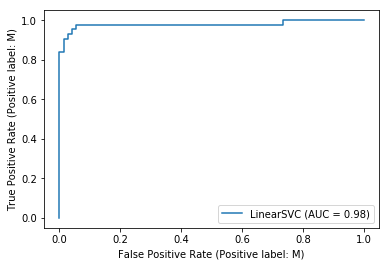

Train Confusion Matrix


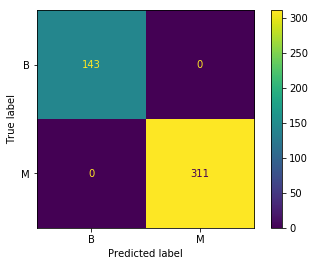

Test Confusion Matrix


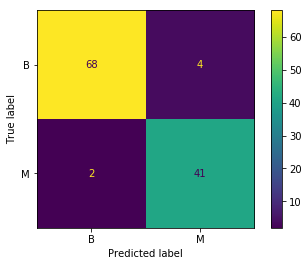

Unsupervised Learning (Training Data):
Train Confusion Matrix


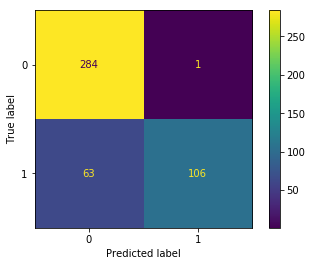

Unsupervised Learning (Test Data):
Test Confusion Matrix


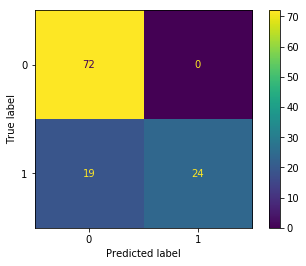

Spectral Clustering (Train Data):
Train Confusion Matrix


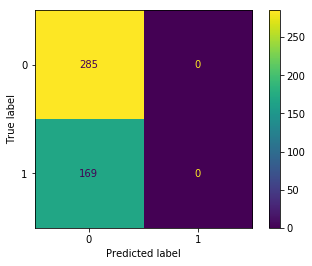

Spectral Clustering (Test Data):
Train Confusion Matrix


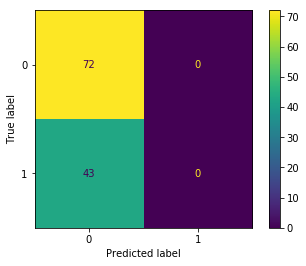

Supervised Learning:
Average Accuracy Score: 0.9652173913043475
Average Precision Score: 0.9534883720930233
Average Recall Score: 0.9534883720930233
Average F1 Score: 0.9534883720930233
Semi- Supervised Learning:
Average Accuracy Score: 0.9689855072463768
Average Precision Score: 0.954976475857077
Average Recall Score: 0.963565891472868
Average F1 Score: 0.9589358880115775
Unsupervised Learning (Training Data):
Average Accuracy Score: 0.8590308370044052
Average Precision Score: 0.9906542056074767
Average Recall Score: 0.6272189349112424
Average F1 Score: 0.7681159420289853
Unsupervised Learning (Test Data):
Average Accuracy Score: 0.8347826086956519
Average Precision Score: 1.0
Average Recall Score: 0.5581395348837208
Average F1 Score: 0.7164179104477609
Spectral Clustering (Train Data):
Average Accuracy Score: 0.6277533039647579
Average Precision Score: 0.0
Average Recall Score: 0.0
Average F1 Score: 0.0
Spectral Clustering (Test Data):
Average Accuracy Score: 0.6260869565217392
Avera

In [13]:
results_supervised_learning = {"Accuracy Score": [], "Precision Score": [], "Recall Score": [], "F1 Score": []}

results_semi_supervised_learning = {"Accuracy Score": [], "Precision Score": [], "Recall Score": [], "F1 Score": []}

results_unsupervised_learning_train = {"Accuracy Score": [], "Precision Score": [], "Recall Score": [], "F1 Score": []}

results_unsupervised_learning_test = {"Accuracy Score": [], "Precision Score": [], "Recall Score": [], "F1 Score": []}

results_spectral_clustering_train = {"Accuracy Score": [], "Precision Score": [], "Recall Score": [], "F1 Score": []}

results_spectral_clustering_test = {"Accuracy Score": [], "Precision Score": [], "Recall Score": [], "F1 Score": []}
# running Monte Carlo Simulation
for run in range(30):
    
    if run == 15:
        plot_roc_and_report_confusion_matrix = True
    else:
        plot_roc_and_report_confusion_matrix = False
        
    
    if plot_roc_and_report_confusion_matrix:
        print("Supervised Learning:")
    results_sl = supervised_learning(plot_roc_and_report_confusion_matrix)
    for key in results_supervised_learning:
        results_supervised_learning[key].append(results_sl[key])
        
    if plot_roc_and_report_confusion_matrix:
        print("Semi- Supervised Learning:")
    labeled_train_data, unlabeled_train_data, best_c = semi_supervised_learning_A()
    results_ssl = semi_supervised_learning_B(labeled_train_data, unlabeled_train_data, best_c, plot_roc_and_report_confusion_matrix)
    for key in results_semi_supervised_learning:
        results_semi_supervised_learning[key].append(results_ssl[key])
        
        
    if plot_roc_and_report_confusion_matrix:
        print("Unsupervised Learning (Training Data):")
    results_train_usl, cluster_1, cluster_2, majority_clust_1, majority_clust_2 = unsupervised_learning_B(plot_roc_and_report_confusion_matrix)
    for key in results_unsupervised_learning_train:
        results_unsupervised_learning_train[key].append(results_train_usl[key])
        
    if plot_roc_and_report_confusion_matrix:
        print("Unsupervised Learning (Test Data):")
    results_test_usl = unsupervised_learning_C(cluster_1, cluster_2, majority_clust_1, majority_clust_2, plot_roc_and_report_confusion_matrix)
    for key in results_unsupervised_learning_test:
        results_unsupervised_learning_test[key].append(results_test_usl[key])
        
        
    if plot_roc_and_report_confusion_matrix:
        print("Spectral Clustering (Train Data):")
    results_train_spectral, distance_df = spectral_cluster_train(plot_roc_and_report_confusion_matrix)
    for key in results_spectral_clustering_train:
        results_spectral_clustering_train[key].append(results_train_spectral[key])
        
    if plot_roc_and_report_confusion_matrix:
        print("Spectral Clustering (Test Data):")
    results_test_spectral = spectral_cluster_test(distance_df, plot_roc_and_report_confusion_matrix)
    for key in results_spectral_clustering_test:
        results_spectral_clustering_test[key].append(results_test_spectral[key])
        
        
        

results_table = [results_supervised_learning, results_semi_supervised_learning, results_unsupervised_learning_train, results_unsupervised_learning_test, results_spectral_clustering_train, results_spectral_clustering_test]

types = ["Supervised Learning:", "Semi- Supervised Learning:", "Unsupervised Learning (Training Data):", "Unsupervised Learning (Test Data):", "Spectral Clustering (Train Data):", "Spectral Clustering (Test Data):"]
       
    
for i in range(len(results_table)):
    print(types[i])
    
    for stat in results_table[i]:
        
        print(f"Average {stat}: {np.mean(results_table[i][stat])}")

Comparing the results that we obtained, we can see that semi-supervised learning performed the best out of all the classifiers (excpet in recall, where it was slightly beat by supervised learning), followed slightly behind by supervised learning, and then there is a big jump to unsupervised learning, and then there was a major drop off for spectral clustering. It is interesting to see how unsupervised learning achieved perfect precision on the test data, yet a relatively poor performance on Recall (0.674), which shows that the positive class does have a cluster where it easy to predict whether in that cluster it is a positive, but some of the positives may leak into the negative cluster.

## 2. Active Learning vs Passive Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [3]:
banknote_authentication_df = pd.read_csv('../data/data_banknote_authentication.txt', names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
attributes = ['variance', 'skewness', 'curtosis', 'entropy']
target = 'class'

testing_banknote = banknote_authentication_df.sample(n=472, replace = False)
training_banknote = banknote_authentication_df.drop(testing_banknote.index)

banknote_authentication_df[target] = banknote_authentication_df[target].apply(int)

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

### (b) Repeat each of the following two procedures 50 times

How to choose parameter ranges for SVMs? One can use wide ranges for the parameters and a fine grid (e.g. 1000 points) for cross validation; however,this method may be computationally expensive. An alternative way is to train the SVM with very large and very small parameters on the whole training data and find very large and very small parameters for which the training accuracy is not below a threshold (e.g., 70%). Then one can select a fixed number of parameters (e.g., 20) between those points for cross validation. For the penalty parameter, usually one has to consider increments in log(λ). For example, if one found that the accuracy of a support vector machine will not be below 70% for λ = 10^−3 and λ = 10^6, one has to choose log(λ) ∈ {−3, −2, . . . , 4, 5, 6}. For the Gaussian Kernel parameter, one usually chooses linear increments,e.g. σ ∈ {.1, .2, . . . , 2}. When both σ and λ are to be chosen using cross-validation, combinations of very small and very large λ’s and σ’s that keep the accuracy above a threshold (e.g.70%) can be used to determine the ranges for σ and λ. Please note that these are very rough rules of thumb, not general procedures.

In [4]:
# choosing which c values to cross validate over
c_cross_val_range = [-8, -7, -6,-5,-4,-3, -2, -1, 0, 1, 2, 3, 4, 5, 6] 

accuracy_scores = []
for c in c_cross_val_range:
    clf = LinearSVC(penalty='l1', C=(10 * (10**c)), dual=False, max_iter= 5000)

    clf.fit(banknote_authentication_df[['variance', 'skewness', 'curtosis', 'entropy']], banknote_authentication_df['class'])

    predictions = clf.predict(banknote_authentication_df[['variance', 'skewness', 'curtosis', 'entropy']])
    
    accuracy_scores.append(accuracy_score(banknote_authentication_df['class'],predictions ))
    
    

# find lower bound with train accuracy above 70%

i = 0
while accuracy_scores[i] < 0.7:
    i += 1
    
lower_bound_c = c_cross_val_range[i]

# find upper bpound with train accuracy above 70%

i = len(accuracy_scores) - 1
while accuracy_scores[i] < 0.7:
    i -= 1
    
upper_bound_c = c_cross_val_range[i]


# choose 20 vals of c between upper and lower bound to cross validate over

increment_by = (upper_bound_c - lower_bound_c) / 19

c_cross_val = [lower_bound_c + (increment_by * i) for i in range(20)]

In [5]:
def tune_c_via_cross_validation(cross_val_search, train):
    best_c = 0
    best_cross_val_score = 0

    # Cross-validation loop to choose the best C value.
    # LinearSVC with 'l1' penalty and maximum iterations of 5000 is used.
    for c in cross_val_search:
        clf = LinearSVC(penalty='l1', C=(10 * (10**c)), dual=False, max_iter= 5000)
        avg_cross_val_score = np.mean(cross_val_score(clf, X= train[attributes], y=train[target].to_numpy().ravel(), cv=5, n_jobs=-1))

        # If the cross-validation score for the current C value is greater than the best score so far,
        # update the best C value and the best cross-validation score.
        if avg_cross_val_score > best_cross_val_score:
            best_c = c
            best_cross_val_score = avg_cross_val_score 
            
    return best_c
            
            
                

### Passive Learning

In [6]:
def passive_learning_monte_carlo(num_monte_carlo_sims = 50, num_resamples = 90, size_per_resample = 10, smote=False,normalize=False):
    passive_tests = []
    for i in range(num_monte_carlo_sims):
        test_scores = []
        banknote_authentication_df_copy = training_banknote.copy()
        if normalize:
            scaler = MinMaxScaler()
            banknote_authentication_df_copy = pd.DataFrame(scaler.fit_transform(banknote_authentication_df_copy), columns= banknote_authentication_df_copy.columns)
        banknote_authentication_df_copy[target] = banknote_authentication_df_copy[target].astype(int)
        
        if smote:
            smote_instance = SMOTE(random_state=42)

            X_resampled, y_resampled = smote_instance.fit_resample(banknote_authentication_df_copy[attributes], banknote_authentication_df_copy[target])

            banknote_authentication_df_copy = X_resampled

            banknote_authentication_df_copy[target] = y_resampled
        train_df = pd.DataFrame(columns = banknote_authentication_df.columns)
        for j in range(num_resamples):

            sampled_df = banknote_authentication_df_copy.sample(n=size_per_resample, replace=False)


            sampled_df[target] = sampled_df[target].astype(int)

            banknote_authentication_df_copy.drop(sampled_df.index, inplace=True)

            train_df = pd.concat([sampled_df, train_df])

            train_df[target] = train_df[target].astype(int)


            best_c = tune_c_via_cross_validation(c_cross_val, train_df.copy())

            final_clf = LinearSVC(penalty='l1', C=(10 * (10**best_c)), dual=False, max_iter= 5000)

            final_clf.fit(train_df[attributes], train_df[target].to_numpy().ravel())

            predictions = final_clf.predict(testing_banknote[attributes])

            test_scores.append(accuracy_score(testing_banknote[target],predictions ))


        passive_tests.append(test_scores)
        
    return passive_tests
                
        # training final model:
        
        

## Active Learning

In [7]:
def active_learning_monte_carlo(num_monte_carlo_sims = 50, num_resamples = 90, size_per_resample = 10, smote=False,normalize=False):
    active_tests = []
    for i in range(num_monte_carlo_sims):
        test_scores = []
        banknote_authentication_df_copy = training_banknote.copy()
        if normalize:
            scaler = MinMaxScaler()
            banknote_authentication_df_copy = pd.DataFrame(scaler.fit_transform(banknote_authentication_df_copy), columns= banknote_authentication_df_copy.columns)
        banknote_authentication_df_copy[target] = banknote_authentication_df_copy[target].astype(int)
        
        if smote:
            smote_instance = SMOTE(random_state=42)

            X_resampled, y_resampled = smote_instance.fit_resample(banknote_authentication_df_copy[attributes], banknote_authentication_df_copy[target])

            banknote_authentication_df_copy = X_resampled

            banknote_authentication_df_copy[target] = y_resampled

        train_df = pd.DataFrame(columns = banknote_authentication_df.columns)

        sampled_df = banknote_authentication_df_copy.groupby('class', group_keys=False).apply(lambda x: x.sample(min(len(x), size_per_resample//2)))


        sampled_df[target] = sampled_df[target].astype(int)


        banknote_authentication_df_copy.drop(sampled_df.index, inplace=True)

        train_df = sampled_df.copy()

        train_df[target] = train_df[target].astype(int)

        best_c = tune_c_via_cross_validation(c_cross_val, train_df.copy())

        final_clf = LinearSVC(penalty='l1', C=(10 * (10**best_c)), dual=False, max_iter= 5000)

        final_clf.fit(train_df[attributes], train_df[target].to_numpy().ravel())

        predictions = final_clf.predict(testing_banknote[attributes])

        test_scores.append(accuracy_score(testing_banknote[target],predictions ))
        for j in range(num_resamples-1):

            # here, compute the distance to the hyperplane (in final_clf) from for each datapoint, and grab ten closes


            banknote_authentication_df_copy['distance_to_hyperplane'] = final_clf.decision_function(banknote_authentication_df_copy[attributes])

            class_1_df = banknote_authentication_df_copy[banknote_authentication_df_copy[target] == 1]
            class_0_df = banknote_authentication_df_copy[banknote_authentication_df_copy[target] == 0]
            sampled_df_1 = class_1_df.nsmallest(min(len(class_1_df), size_per_resample //2), 'distance_to_hyperplane')
            sampled_df_2 = class_0_df.nsmallest(min(len(class_0_df), size_per_resample //2), 'distance_to_hyperplane')
            sampled_df = pd.concat([sampled_df_1, sampled_df_2])
            train_df = pd.concat([train_df, sampled_df])
            banknote_authentication_df_copy.drop(sampled_df.index, inplace=True)

            best_c = tune_c_via_cross_validation(c_cross_val, train_df.copy())             

            final_clf = LinearSVC(penalty='l1', C=(10 * (10**best_c)), dual=False, max_iter= 5000)

            final_clf.fit(train_df[attributes], train_df[target].to_numpy().ravel())

            predictions = final_clf.predict(testing_banknote[attributes])

            test_scores.append(accuracy_score(testing_banknote[target],predictions ))


        active_tests.append(test_scores)
    
    return active_tests


### Comparison

In [17]:
def run_monte_carlo_sims(num_monte_carlo_sims = 50, num_resamples = 90, size_per_resample = 10, smote=False,normalize=False):
    active_tests = active_learning_monte_carlo(num_monte_carlo_sims, num_resamples, size_per_resample, smote,normalize)
    passive_tests = passive_learning_monte_carlo(num_monte_carlo_sims, num_resamples, size_per_resample, smote,normalize)
    
    return active_tests, passive_tests

In [18]:
def compare(active_tests, passive_tests, smote, normalize):
    active_test_averages = [sum(col) / len(col) for col in zip(*active_tests)]

    passive_test_averages = [sum(col) / len(col) for col in zip(*passive_tests)]
    num_of_training_instances = [10 * i for i in range(1,91)]
    plt.plot(num_of_training_instances, passive_test_averages, label='Passive Learning', color='blue', linestyle='-')

    # Plot y2 vs. x
    plt.plot(num_of_training_instances, active_test_averages, label='Active Learning', color='red', linestyle='-')

    # Adding title and labels
    title_str = 'Passive vs Active Learning'
    if smote or normalize:
        title_str += ' with'
        
        if smote and normalize:
            title_str += ' Normalization and SMOTE'
        elif smote:
            title_str += ' SMOTE'
        else:
            title_str += ' Normalization'
    
    title_str += ' on Banknote Dataset'
            
    plt.title(title_str)
    plt.xlabel('Number of training data points')
    plt.ylabel('Classification Accuracy')

    # Displaying the legend
    plt.legend()

    # Displaying the plot
    plt.show()

### Running without SMOTE and without Normalization and comparing performance

In [ ]:
%%capture
active, passive = run_monte_carlo_sims()

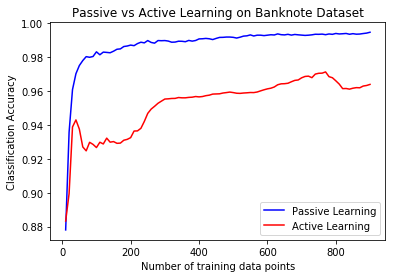

In [12]:
compare(active, passive, smote=False, normalize=False)

### Running without Normalization and comparing performance

In [ ]:
%%capture
active, passive = run_monte_carlo_sims(smote=True)

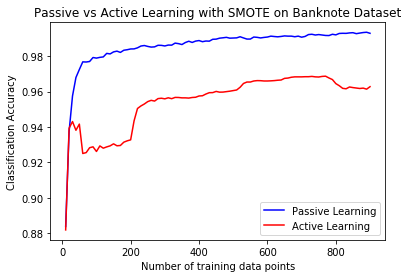

In [21]:
compare(active, passive, smote=True, normalize=False)

### Running without SMOTE and comparing performance

In [ ]:
%%capture
active, passive = run_monte_carlo_sims(normalize=True)

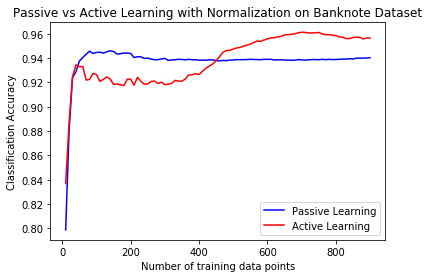

In [20]:
compare(active, passive, smote=False, normalize=True)

### Running with SMOTE and Normalization and comparing performance

In [ ]:
%%capture
active, passive = run_monte_carlo_sims(normalize=True, smote=True)


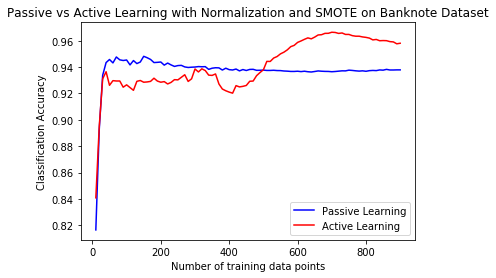

In [22]:
compare(active, passive, smote=True, normalize=True)

As we can see, without normalization, passive learning consistently outperformed active learning, even with SMOTE applied. However, when normalization is applied, active learning on average surpassed the passive learning performance at around ~500 training data points. This is likely due to the fact that normalization allows for a more consistent distance calculation, a crucial step in active learning in determing how the next SVM will be trained. Also, it is important to note that accuracy seemed to decrease overall when data is normalized, as >98% accuracy was achieved without normalization via passive learning but ~96% accuracy was achieved with passive learning. In the future, it might be worth trying other types of SVMs and see if this behavior is similar on the dataset.